In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
%matplotlib inline
import json
import seaborn
import re
import seaborn as sns
import json
from scipy import stats

## Load the data using pandas

In [2]:
df = pd.read_csv('data.csv', parse_dates=True, dtype = {'Id':'string', 'Title': 'string', 'Company': 'string', 'Date': 'string', 'Location': 'string', 'Area': 'string', 'Classification': 'string', 'SubClassification': 'string', 'Requirement': 'string', 'FullDescription': 'string', 'LowestSalary': 'int', 'HighestSalary': 'int', 'JobType': 'string'})

## Clean the data

In [3]:
df['Id'] = df['Id'].str.extract('(^[0-9]+)').astype(int)                         
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
print('\n', df.dtypes)


 Id                                 int32
Title                             string
Company                           string
Date                 datetime64[ns, UTC]
Location                          string
Area                              string
Classification                    string
SubClassification                 string
Requirement                       string
FullDescription                   string
LowestSalary                       int32
HighestSalary                      int32
JobType                           string
dtype: object


## Set up data structure to hold cities/sectors/salaries

In [6]:
class SubSector:
    def __init__(self, name):
        self.salaries = list()
        self.name = name
    def __str__(self):
        return self.name 
    def AddSalary(self, lowest, highest):
        self.salaries.append((lowest, highest))
    def NumSalaries(self):
        return len(self.salaries)
    def AvgSalary(self):
        total = 0
        for tup in self.salaries:
            total += tup[1]
        return total / self.NumSalaries()
    def AllSalaries(self, mode = "max"):
        allSalaries = list()
        for salary in self.salaries:
            val = 0
            if mode == "min":
                val = salary[0]
            elif mode == "max":
                val = salary[1]
            elif mode == "avg":
                val = (salary[0] + salary[1]) / 2
            allSalaries.append((self.name, val))
        return allSalaries

class Sector:
    def __init__(self, name):
        self.subSectors = dict()
        self.name = name
    def __str__(self):
        return self.name 
    def AddSubSector(self, subSector, lowestSalary, highestSalary):
        if subSector not in self.subSectors:
            self.subSectors.update({subSector : SubSector(subSector)})
        self.subSectors[subSector].AddSalary(lowestSalary, highestSalary)
    def MostDominantSubSector(self):
        subSector = object()
        amt = 0
        for key in self.subSectors:
            cur = self.subSectors[key]
            curAmt = cur.NumSalaries()
            if cur > amt:
                amt = cur
                subSector = cur
        return subSector
    def NumSubSectors(self):
        return len(self.subSectors)
    def AvgSalary(self):
        total = 0
        for key in self.subSectors:
            subSector = self.subSectors[key]
            total += subSector.AvgSalary()
        return total / self.NumSubSectors()
    def AllSalaries(self, mode = "max"):
        allSalaries = list()
        for key in self.subSectors:
            subSector = self.subSectors[key]
            subSalaries = subSector.AllSalaries(mode)
            for subSalary in subSalaries:
                allSalaries.append((self.name, subSalary[0], subSalary[1]))
        return allSalaries

class City:
    def __init__(self, name):
        self.sectors = dict()
        self.sectorCounts = dict()
        self.name = name
        self.capital = name in ["Canberra", "Sydney", "Darwin", "Brisbane", "Adelaide", "Hobart", "Melbourne", "Perth", "ACT"]
    def IsCapital(self):
        return self.capital
    def __str__(self):
        return self.name 
    def AddSector(self, sector, subSector, lowestSalary, highestSalary):
        if sector not in self.sectors:
            self.sectorCounts.update({sector : 1})
            self.sectors.update({sector: Sector(sector)})
        else:
            self.sectorCounts[sector] += 1
        self.sectors[sector].AddSubSector(subSector, lowestSalary, highestSalary)
    def MostDominantSector(self):
        sector = object()
        amt = 0
        for key in self.sectorCounts:
            cur = self.sectorCounts[key]
            if cur > amt:
                amt = cur
                sector = self.sectors[key]
        return sector
    def NumSectors(self):
        return len(self.sectors)
    def AvgSalary(self):
        total = 0
        for key in self.sectors:
            total += self.sectors[key].AvgSalary()
        return total / self.NumSectors()
    def AllSalaries(self, mode = "max"):
        allSalaries = list()
        for key in self.sectors:
            sector = self.sectors[key]
            salaries = sector.AllSalaries(mode)
            for salary in salaries:
                allSalaries.append((self.name, salary[0], salary[1], salary[2]))
        return allSalaries
    def SectorCountList(self):
        sectorList = list()
        for key in self.sectors:
            sector = self.sectors[key]
            count = self.sectorCounts[key]
            sectorList.append((str(sector), count))
        return sectorList

cityDict = dict()
for index, row in df.iterrows():
    city = row["Location"]
    sector = row["Classification"]
    subSector = row["SubClassification"]
    lowestSalary = row["LowestSalary"]
    highestSalary = row["HighestSalary"]
    
    if not pd.isnull(city) and not pd.isnull(sector) and not pd.isnull(subSector) and not pd.isnull(lowestSalary) and not pd.isnull(highestSalary): 
        if city not in cityDict:
            cityDict.update({city : City(city)})
        cityDict[city].AddSector(sector, subSector, lowestSalary, highestSalary)

In [7]:
allCities = list()
capitals = list()
nonCapitals = list()
for key in cityDict:
    cur = cityDict[key]
    allCities.append(cur)
    if cityDict[key].IsCapital():
        capitals.append(cur)
    else:
        nonCapitals.append(cur)

### Bubble graph (hypothesis 1)

In [8]:
rootChildren = []
for city in allCities:
    cityChildren = []
    isCap = 'purple'
    if city in capitals:
        isCap = 'orange'
    for child in city.SectorCountList():
        cur = {
            "name": child[0],
            "size": child[1]
        }
        cityChildren.append(cur)
    
    cityRoot = {
        "name": str(city),
        "iscaptial": isCap,
        "children": cityChildren
    }
    
    rootChildren.append(cityRoot)
    
root = {
    "name": "Cities",
    "children": rootChildren
}

with open('H1_BubbleGraph.json', 'w') as outfile:
    jsonStr = json.loads(json.dumps(root))
    json.dump(jsonStr, outfile)

### Bar graph (hypothesis 1)

In [10]:
cityAverages = []
for city in allCities:
    totalTech = 0
    totalOthers = 0
    isCap = "purple"
    if city in capitals:
        isCap = "orange"
    for child in city.SectorCountList():
        if child[0] == "Information & Communication Technology":
            totalTech += child[1]
        else:
            totalOthers += child[1]
    percentTech = (totalTech / (totalTech + totalOthers)) * 100
    
    root = {
        "area": str(city),
        "value": round(percentTech, 2),
        "iscapital": isCap
    }
    if percentTech > 0:
        cityAverages.append(root)
        
with open('H1_BarGraph.json', 'w') as outfile:
    jsonStr = json.loads(json.dumps(cityAverages))
    json.dump(jsonStr, outfile)

### Methods to help with forecasting

In [12]:
import datetime

def GetPeriodDf_Salary(inputDF):
    # create salary df
    salary_df = inputDF[["Date", "HighestSalary"]]
    salary_df = salary_df.rename(columns = {'HighestSalary': 'Salary'} )
    salary_df.sort_values(by=["Date"], inplace=True, ascending=True)
    
    startTime = salary_df.iloc[0]["Date"]
    salary_df['Period'] = salary_df["Date"].dt.isocalendar().week + ((salary_df["Date"].dt.isocalendar().year - startTime.year) * 52)
    
    # create peropd df
    period_df = pd.DataFrame(columns=['Period', 'TotalSalary', 'NumSalaries'])
    
    # data for getting the periods
    periods = list()
    salaries = list()
    amounts = list()
    
    curPeriod = -1
    curTotal = 0
    curAmt = 0
    
    # calculate the periods
    for index, row in salary_df.iterrows():
        period = row['Period']
        salary = row['Salary']

        if curPeriod == -1:
            curPeriod = period
        
        if period != curPeriod:
            periods.append(curPeriod)
            salaries.append(curTotal)
            amounts.append(curAmt)
            curPeriod = period
            curTotal = 0
            curAmt = 0

        curTotal += salary
        curAmt += 1
    
    periods.append(curPeriod)
    salaries.append(curTotal)
    amounts.append(curAmt)

    # populate the period df
    period_df["Period"] = periods
    period_df["TotalSalary"] = salaries
    period_df["NumSalaries"] = amounts
    period_df["AvgSalary"] = period_df["TotalSalary"] / period_df["NumSalaries"]
    
    return period_df

def GetPeriods(inputDF):
    salary_df = inputDF[["Date", "HighestSalary"]].copy()
    salary_df = salary_df.rename(columns = {'HighestSalary': 'Salary'} )
    salary_df.sort_values(by=["Date"], inplace=True, ascending=True)
    
    startTime = salary_df.iloc[0]["Date"]
    salary_df['Period'] = salary_df["Date"].dt.isocalendar().week + ((salary_df["Date"].dt.isocalendar().year - startTime.year) * 52)
    
    periods = list()
    periodDates = list()
    
    # calculate the periods
    for index, row in salary_df.iterrows():
        period = row['Period']
        date = row['Date']
        if period not in periods:
            periods.append(period)
            
            year = date.year
            month = datetime.date(1900, date.month, 1).strftime('%B')
            
            dateStr = month + " " + str(year)
            periodDates.append(dateStr)
    
    return periods, periodDates

def MovingAverage(df, column, newColumn, periodColumn, k, numPeriods):
    values = df[column].values.copy()
    
    df[newColumn] = df[column]
    for m in range(k, numPeriods):
        if m < k:
            sale_predict = float('nan')
        else:
            history = values[m-k:m]
            sale_predict = sum(history) / k
        
        df[newColumn][m] = sale_predict
        if (values[m] == 0):
            values[m] = sale_predict

    return df

def ExponentialSmoothing(df, column, newColumn, alpha, length):
    values = [df[column][0]]
    for m in range(0, len(df)):
        if df[column][m] == 0: # we are forecasting
            values.append((alpha * df[column][length-1]) + ((1 - alpha) * values[m]))
        else:
            values.append((alpha * df[column][m]) + ((1-alpha) * values[m]))
    
    df[newColumn] = values[0:len(values)-1]
    #df[newColumn] = values[1:] 
    
    return df

def AddPeriods(df, fromPeriod, toPeriod):
    for i in range(fromPeriod, toPeriod + 1):
        df = df.append({"Period": i, "AvgSalary": 0, "NumSalaries": 0, "AvgSalary": 0}, ignore_index=True)
    return df

# Do some forecasting for hypothesis 3, testing moving average / exponential smoothing

### Get the periods for each of the sectors

In [37]:
techPeriodDF = GetPeriodDf_Salary(df.loc[df['Classification'] == "Information & Communication Technology"])
healthPeriodDF = GetPeriodDf_Salary(df.loc[df['Classification'] == "Healthcare & Medical"])
retailPeriodDF = GetPeriodDf_Salary(df.loc[df['Classification'] == "Retail & Consumer Products"])
manufacturingPeriodDF = GetPeriodDf_Salary(df.loc[df['Classification'] == "Manufacturing, Transport & Logistics"])
accountingPeriodDF = GetPeriodDf_Salary(df.loc[df['Classification'] == "Accounting"])
allDF = GetPeriodDf_Salary(df)

periods, periodDates = GetPeriods(df)

### Add missing periods

In [38]:
techPeriodDF = AddPeriods(techPeriodDF, 51, 63)
healthPeriodDF = AddPeriods(healthPeriodDF, 51, 63)
retailPeriodDF = AddPeriods(retailPeriodDF, 51, 63)
manufacturingPeriodDF = AddPeriods(manufacturingPeriodDF, 51, 63)
accountingPeriodDF = AddPeriods(accountingPeriodDF, 51, 63)

### Perform exponential smoothing + moving average

In [39]:
analysisColumnName = "AvgSalary"
#analysisColumnName = "NumSalaries"

k=4
techPeriodDF = MovingAverage(techPeriodDF, analysisColumnName, 'MovingAverage', 'Period', k, len(periods))
healthPeriodDF = MovingAverage(healthPeriodDF, analysisColumnName, 'MovingAverage', 'Period', k, len(periods))
retailPeriodDF = MovingAverage(retailPeriodDF, analysisColumnName, 'MovingAverage', 'Period', k, len(periods))
manufacturingPeriodDF = MovingAverage(manufacturingPeriodDF, analysisColumnName, 'MovingAverage', 'Period', k, len(periods))
accountingPeriodDF = MovingAverage(accountingPeriodDF, analysisColumnName, 'MovingAverage', 'Period', k, len(periods))

alpha = 0.2
length = 11
techPeriodDF = ExponentialSmoothing(techPeriodDF, analysisColumnName, 'ExpSmoothing', alpha, length)
healthPeriodDF = ExponentialSmoothing(healthPeriodDF, analysisColumnName, 'ExpSmoothing', alpha, length)
retailPeriodDF = ExponentialSmoothing(retailPeriodDF, analysisColumnName, 'ExpSmoothing', alpha, length)
manufacturingPeriodDF = ExponentialSmoothing(manufacturingPeriodDF, analysisColumnName, 'ExpSmoothing', alpha, length)
accountingPeriodDF = ExponentialSmoothing(accountingPeriodDF, analysisColumnName, 'ExpSmoothing', alpha, length)

### Generate the graph

[]

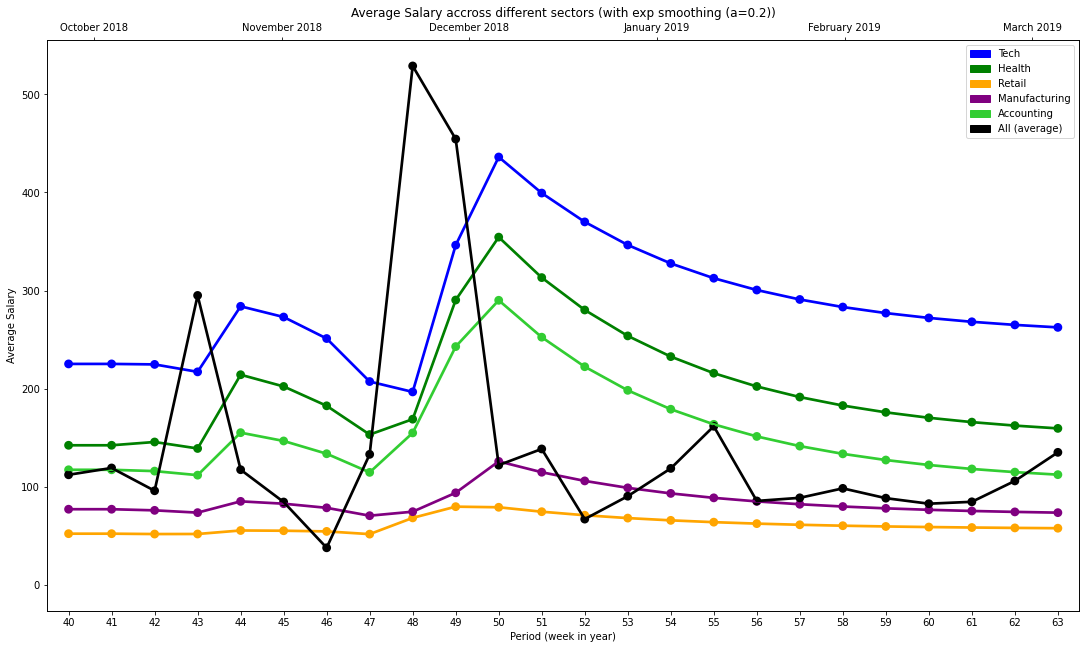

In [40]:
import matplotlib.patches as mpatches

def GetPeriodVal(df, period, column = "AvgSalary"):
    val = 0
    if ((df['Period'] == period).any()):
        val = df.loc[df['Period'] == period, column].iloc[0]
    return val

#technique = "MovingAverage"
technique = "ExpSmoothing"
outDF = pd.DataFrame(columns = ["Period", "Tech", "Health", "Retail", "Manufacturing", "Accounting"])
for period in periods:
    techVal = GetPeriodVal(techPeriodDF, period, technique)
    healthVal = GetPeriodVal(healthPeriodDF, period, technique)
    retailVal = GetPeriodVal(retailPeriodDF, period, technique)
    manufacturingVal = GetPeriodVal(manufacturingPeriodDF, period, technique)
    accountingVal = GetPeriodVal(accountingPeriodDF, period, technique)

    valList = [techVal, healthVal, retailVal, manufacturingVal, accountingVal]

    if (sum(valList) == 0):
        break

    outDF = outDF.append({"Period": period, "Tech": techVal, "Health": healthVal, "Retail": retailVal, "Manufacturing": manufacturingVal, "Accounting": accountingVal}, ignore_index=True)

# make the graph
techColor = 'blue'
healthColor = 'green'
retailColor = 'orange'
manufacturingColor = 'purple'
accountingColor = 'limegreen'
allColor = 'black'

techPatch = mpatches.Patch(color=techColor, label='Tech')
healthPatch = mpatches.Patch(color=healthColor, label='Health')
retailPatch = mpatches.Patch(color=retailColor, label='Retail')
manufacturingPatch = mpatches.Patch(color=manufacturingColor, label='Manufacturing')
accountingPatch = mpatches.Patch(color=accountingColor, label='Accounting')
allPatch = mpatches.Patch(color=allColor, label='All (average)')

f, ax = plt.subplots(1, 1)

sns.pointplot(x='Period', y='Tech', data=outDF, color=techColor)
sns.pointplot(x='Period', y='Health', data=outDF, color=healthColor)
sns.pointplot(x='Period', y='Retail', data=outDF, color=retailColor)
sns.pointplot(x='Period', y='Manufacturing', data=outDF, color=manufacturingColor)
sns.pointplot(x='Period', y='Accounting', data=outDF, color=accountingColor)
sns.pointplot(x='Period', y=analysisColumnName, data=allDF, color=allColor)

ax2 = ax.twiny()
ax2.plot(periodDates, np.zeros(len(periodDates)), alpha=0)

#ax.set_title("Average Salary different sectors (with moving average (k=" + str(k) + "))")
ax.set_title("Average Salary accross different sectors (with exp smoothing (a=" + str(alpha) + "))")
plt.legend(handles=[techPatch, healthPatch, retailPatch, manufacturingPatch, accountingPatch, allPatch])
ax.set_ylabel("Average Salary")
ax.set_xlabel("Period (week in year)")

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.plot()

#compression_opts = dict(method='zip', archive_name='out.csv')  
#outDF.to_csv('out.zip', index=False, compression=compression_opts)  

# Investigate errors of moving average vs exponential smoothing

In [60]:
allDF_half = allDF[:11]
allDF_half = AddPeriods(allDF_half, 51, 63)

analysisColumnName = "AvgSalary"
#analysisColumnName = "NumSalaries"

k = 2
allDF_half = MovingAverage(allDF_half, analysisColumnName, 'MovingAverage', 'Period', k, len(periods))

alpha = 0.7
allDF_half = ExponentialSmoothing(allDF_half, analysisColumnName, 'ExpSmoothing', alpha, 11)
allDF_half["Actual"] = allDF[analysisColumnName]

[]

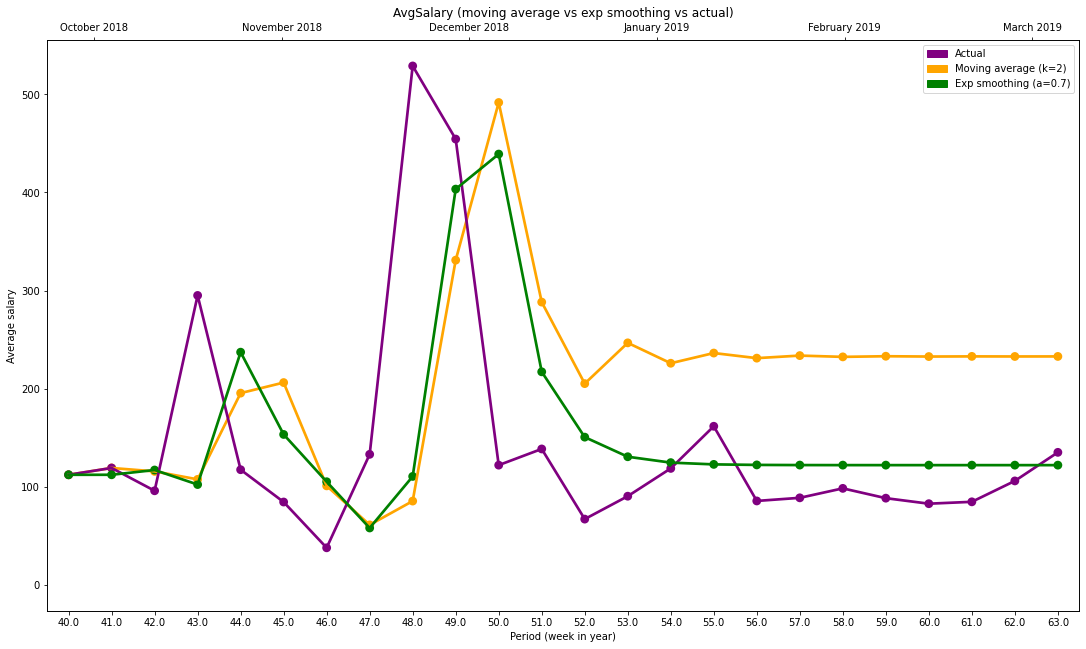

In [61]:
# make the graph
actualColor = 'purple'
predictColor = 'orange'
expColor = 'green'

actualPatch = mpatches.Patch(color=actualColor, label='Actual')
predictPatch = mpatches.Patch(color=predictColor, label='Moving average (k=' + str(k) + ')')
expPatch = mpatches.Patch(color=expColor, label='Exp smoothing (a=' + str(alpha) + ')')

f, ax = plt.subplots(1, 1)

sns.pointplot(x='Period', y='MovingAverage', data=allDF_half, color=predictColor)
sns.pointplot(x='Period', y='Actual', data=allDF_half, color=actualColor)
sns.pointplot(x='Period', y='ExpSmoothing', data=allDF_half, color=expColor)

ax2 = ax.twiny()
ax2.plot(periodDates, np.zeros(len(periodDates)), alpha=0)

ax.set_title(str(analysisColumnName) + " (moving average vs exp smoothing vs actual)")
plt.legend(handles=[actualPatch, predictPatch, expPatch])
ax.set_ylabel("Average salary")
ax.set_xlabel("Period (week in year)")

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.plot()

### 

In [45]:
import math
def MSE(real, pred):
    total = 0
    N = len(real)
    for i in range(N):
        diff = real[i] - pred[i]
        diff2 = diff * diff
        total += diff2
    mse = total / N
    return mse

def RMSE(real, pred):
    return math.sqrt(MSE(real, pred))

realList = allDF_half["Actual"].tolist()
averageList = allDF_half["MovingAverage"].tolist()
smoothingList = allDF_half["ExpSmoothing"].tolist()

mse_avg = MSE(realList, averageList)
rmse_avg = RMSE(realList, averageList)

mse_smooth = MSE(realList, smoothingList)
rmse_smooth = RMSE(realList, smoothingList)

print("MSE:")
print("Avg: ", mse_avg, "Smooth: ", mse_smooth)
print("RMSE:")
print("Avg: ", rmse_avg, "Smooth: ", rmse_smooth)

MSE:
Avg:  27016.531033747724 Smooth:  15373.724561277157
RMSE:
Avg:  164.36706188816459 Smooth:  123.99082450438483


# Box plots for hypothesis 2

Information & Communication Technology
Healthcare & Medical
Manufacturing, Transport & Logistics
Accounting
Construction


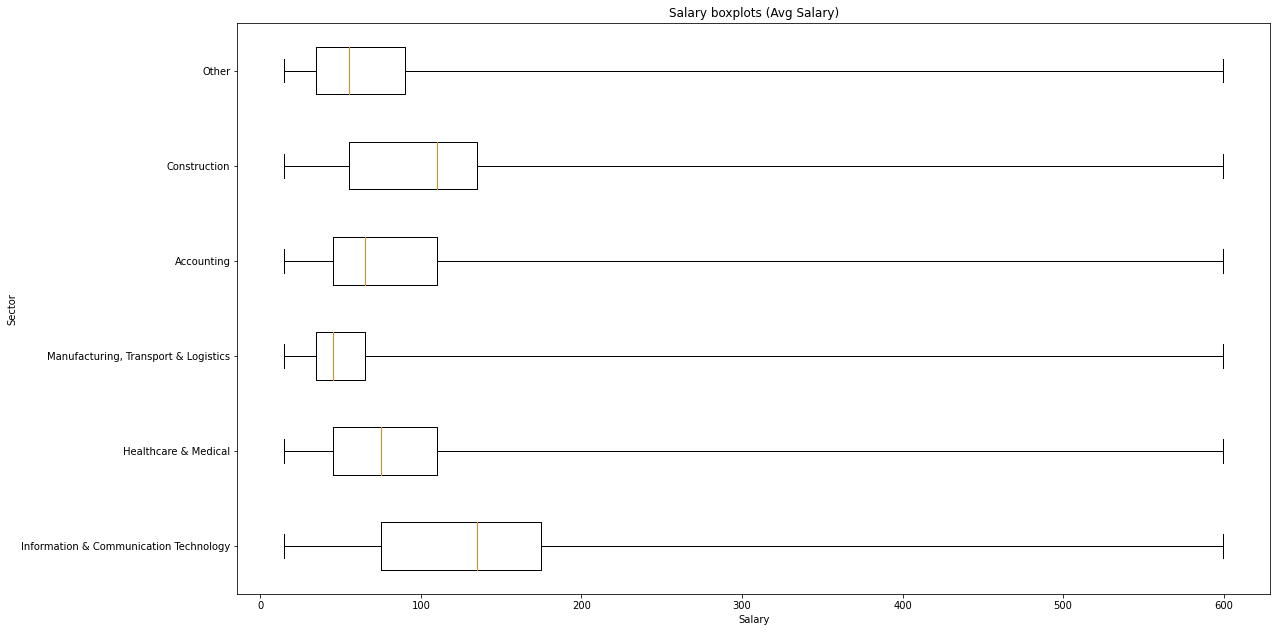

In [22]:
def AnalyseSalaries(salaries, label):
    nums = []
    for salary in salaries:
        nums.append(salary[3])

    nums_np = np.array(nums)
    mean = np.mean(nums)
    median = np.median(nums)
    std = np.std(nums)
    var = np.var(nums)
    q1 = np.quantile(nums, 0.25)
    q3 = np.quantile(nums, 0.75)
    _min = np.min(nums)
    _max = np.max(nums)
    
    obj = {
        "label": label,
        "whislo": _min.item(),
        "q1": q1.item(),
        "med": median.item(),
        "q3": q3.item(),
        "whishi": _max.item(),
        'fliers': []
    }
    return obj

mode = "Avg"

allSalaries = []
for key in cityDict:
    salaries = cityDict[key].AllSalaries(mode.lower())
    for salary in salaries:
        allSalaries.append(salary)

salaryDict = dict()
for salary in allSalaries:
    sector = salary[1]
    if sector not in salaryDict:
        salaryDict.update({sector: list()})
    salaryDict[sector].append(salary)

salaryList = list()
for key in salaryDict:
    salaryList.append((key, salaryDict[key]))

salaryList.sort(key=lambda tup: len(tup[1]), reverse=True)

allAnalysis = []
for i in range(5):
    tup = salaryList[i]
    salaryList.remove(tup)
    sector = tup[0]
    salaries = tup[1]
    analysis = AnalyseSalaries(salaries, sector)
    allAnalysis.append(analysis)
    print(sector)
    
otherSalaries = []
for tup in salaryList:
    for salary in tup[1]:
        otherSalaries.append(salary)
        
otherAnalysis = AnalyseSalaries(otherSalaries, "Other")

allAnalysis.append(otherAnalysis)

#plots = [techAnalysis, otherAnalysis]
#with open('H2_Boxplot.json', 'w') as outfile:
#    json.dump(plots, outfile)

fig, ax = plt.subplots()

ax.bxp(allAnalysis, showfliers=False, vert=False)
ax.set_xlabel("Salary")
ax.set_ylabel("Sector")
ax.set_title("Salary boxplots (" + mode + " Salary)")
fig.set_size_inches(18.5, 10.5)
plt.savefig("H2_Boxplot_" + mode, facecolor='white', transparent=False, bbox_inches='tight')
plt.show()

# Bar chart for hypothesis 2

In [65]:
def GetPercentile(salaries, percentage):
    nums = []
    for salary in salaries:
        nums.append(salary[3])
    nums.sort(reverse=True)
    
    amount = round(len(nums) * percentage)
    
    total = 0
    for i in range(amount):
        total += nums[i]
    
    return round(total / amount, 2)

salaryList.clear()
for key in salaryDict:
    salaryList.append((key, salaryDict[key]))

salaryList.sort(key=lambda tup: len(tup[1]), reverse=True)

cityBars = []
for i in range(5):
    tup = salaryList[i]
    salaries = tup[1]
    avg5 = GetPercentile(salaries, 0.05)
    avg25 = GetPercentile(salaries, 0.25)
    avg50 = GetPercentile(salaries, 0.5)
    avg75 = GetPercentile(salaries, 0.75)
    
    obj = {
        "sector": tup[0],
        "values": [
            {
                "value": avg5,
                "percent": "Top 5%"
            },
            {
                "value": avg25,
                "percent": "Top 25%"
            },
            {
                "value": avg50,
                "percent": "Top 50%"
            },
            {
                "value": avg75,
                "percent": "Top 75%"
            },
        ]
    }
    
    cityBars.append(obj)
    
with open('H2_BarChart.json', 'w') as outfile:
    json.dump(cityBars, outfile)

## Case study 1

### Get a list of the texts to analyse

In [26]:
import nltk
from nltk.corpus import stopwords
import re
import string

requirements = list()
for index, row in df.iterrows():
    sector = str(row["Classification"])
    
    if sector == "Information & Communication Technology":
        requirement = str(row["Requirement"]).strip()
        description = str(row["FullDescription"]).strip()
        requirements.append(requirement)
        requirements.append(description)

In [27]:
def remove_html_tags(text):
    """Remove html tags from a string"""
    import re
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

requirements_filtered = list()
for requirement in requirements:
    raw = requirement.lower()

    raw1 = re.sub(r'\d+', '', raw)
    raw2 = "".join(c for c in raw1 if c not in ("?", ".", ";", ":", "!", "+", ",", "'"))
    raw3 = " ".join(raw2.split())
    raw4 = remove_html_tags(raw3)

    requirements_filtered.append(raw4)

### Get the frequencies

In [28]:
skills = set(["c++", "cpp", "java", "javascript", "python", "html", "css", "c#", "sql", "nosql", "rust", "perl", "go", "c", "php", "swift", 
              "objective-c", "assembly", "rust", "js", "asp", "vb.net", "ssi", "tcl", "vrml", "typescript", "r", "vba", "scala", "visual basic", "lua",
              "dart", "haskell", "cobol", "matlab", "kotlin", "abap", "julia", "groovy", "pascal", "delphi", "shell", "fortran", "f#", "postscript", "latex"
              
              "node", "express", "django", "rails", "laravel", "spring", "angular", "react", "vue", "ember", "backbone",
              "jquery", "r studio"
              "xml", "json",
              "unity", "unreal", "godot",
              "oracle", "mysql", "sql server", "postgre", "mongodb", "db2", "redis", "sqlite", "access",
              "math", "statistics", "science", "algorithm", "algorithms", "maths",
              "intelligent system", "big data", "data", "big Data analysis", "data science",
              "visual studio", "dreamweaver",
              "scripting", "qa"])

frequencies = dict()
for requirement in requirements_filtered:
    for word in requirement.split():
        if word in skills:
            if word in frequencies:
                frequencies[word] += 1
            else:
                frequencies[word] = 1
         
# print the word cloud
wordcloud = ""
for key in frequencies:
    count = frequencies[key]
    for i in range(count):
        wordcloud += key + " "
        
#print(wordcloud)

['green', 'orange', 'cyan', 'green', 'red', 'green', 'cyan', 'cyan', 'green', 'red', 'red', 'blue', 'blue', 'green', 'red', 'blue', 'orange', 'red', 'red', 'green', 'orange', 'blue', 'purple', 'red', 'orange', 'blue', 'red', 'orange', 'green', 'purple', 'red', 'cyan', 'orange', 'purple', 'purple', 'green', 'purple', 'cyan', 'purple', 'cyan', 'orange', 'red', 'orange', 'blue', 'blue', 'cyan', 'cyan', 'red', 'blue', 'orange', 'cyan', 'cyan', 'orange', 'red', 'blue', 'orange', 'green', 'cyan', 'purple', 'green', 'red', 'red', 'green', 'orange', 'green', 'orange', 'cyan', 'green']


[]

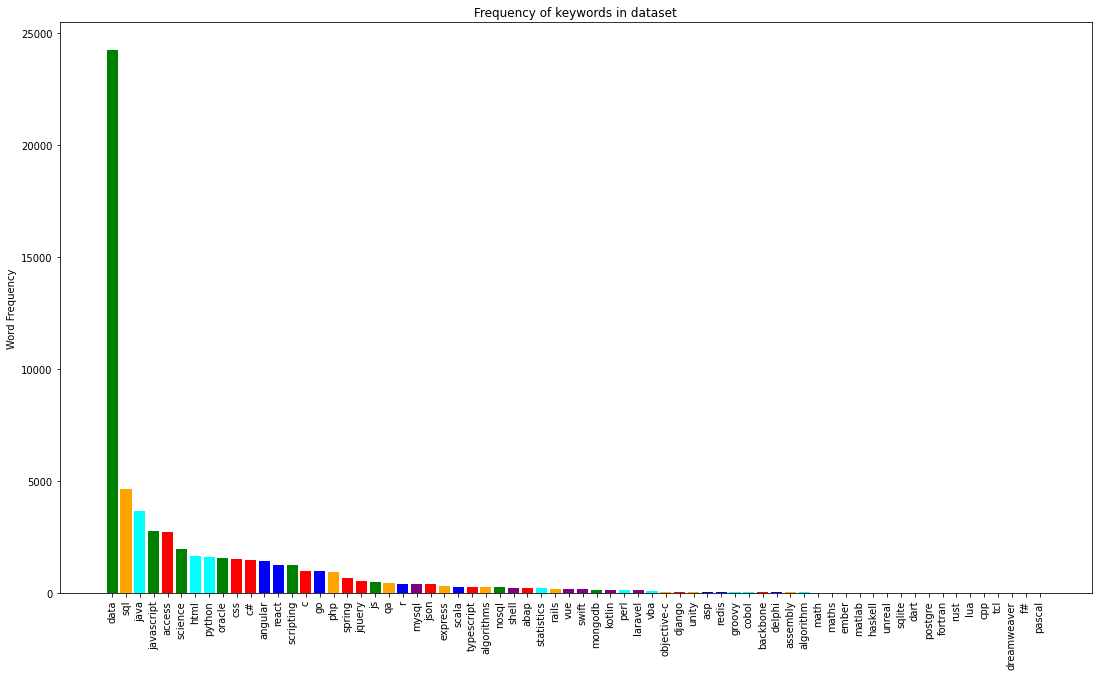

In [29]:
import random
rand = random.SystemRandom()

tups = []
for key in frequencies:
    tups.append((key, frequencies[key]))
tups.sort(key=lambda tup: tup[1], reverse=True)
    
yVals = []
xLabels = []
for tup in tups:
    xLabels.append(tup[0])
    yVals.append(tup[1])

colorSet = ['orange', 'red', 'green', 'blue', 'cyan', 'purple']
colors = []
for i in range(len(xLabels)):
    colors.append(rand.choice(colorSet))
print(colors)
f, ax = plt.subplots(1, 1)


plt.bar(xLabels, yVals, color=colors)

ax.set_title("Frequency of keywords in dataset")
ax.set_ylabel("Word Frequency")

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.xticks(rotation=90)
plt.plot()